In [1]:
import torch
from torch import nn

class SimpleCNN(nn.Module):
    def __init__(self, in_ch, out_ch, n_filters, kernel_size=3):
        super().__init__()

        # Define (convolution) layers -> NOTE: padding="same" means "padded convolution"
        self.conv1 = nn.Conv2d(in_channels=in_ch, out_channels=n_filters, kernel_size=kernel_size, padding="same")
        self.conv2 = nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=kernel_size, padding="same")
        self.conv3 = nn.Conv2d(in_channels=n_filters, out_channels=out_ch, kernel_size=kernel_size, padding="same")

        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.conv1(x))
        h = self.relu(self.conv2(h))
        out = self.conv3(h)
        return out

/Users/davideevangelista/computational-imaging/end-to-end/../IPPy/operators.py:16: UserWarning: CuPy not found. GPU acceleration for ASTRA via CuPy will be disabled.
  warnings.warn(


Shape of x_true: torch.Size([1, 1, 256, 256]). Range of x_true: (tensor(0.), tensor(1.))
SSIM: 0.9404


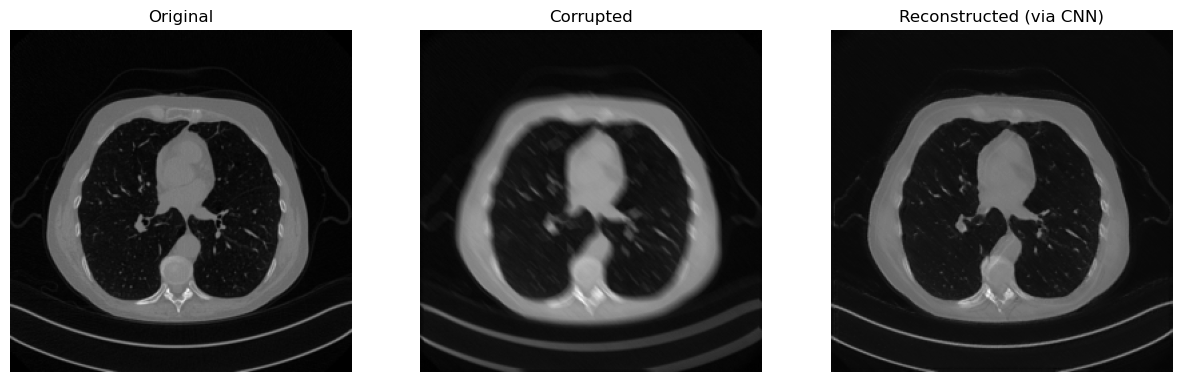

In [2]:
#-----------------
# This is just for rendering on the website
import os
import sys
import glob
sys.path.append("..")
#-----------------

from IPPy import operators, utilities, metrics

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = utilities.get_device()

# Define model
model = SimpleCNN(in_ch=1, out_ch=1, n_filters=64, kernel_size=3).to(device)

# Load model weights and send to CUDA
model.load_state_dict(torch.load("../weights/CNN.pth", weights_only=True, map_location=torch.device('cpu')))
model = model.to(device)

# Generate test image
class MayoDataset(Dataset):
    def __init__(self, data_path, data_shape):
        super().__init__()

        self.data_path = data_path
        self.data_shape = data_shape

        # We expect data_path to be like "./data/Mayo/train" or "./data/Mayo/test"
        self.fname_list = glob.glob(f"{data_path}/*/*.png")

    def __len__(self):
        return len(self.fname_list)
    
    def __getitem__(self, idx):
        # Load the idx's image from fname_list
        img_path = self.fname_list[idx]

         # To load the image as grey-scale
        x = Image.open(img_path).convert("L")

        # Convert to numpy array -> (512, 512)
        x = np.array(x) 

        # Convert to pytorch tensor -> (1, 512, 512) <-> (c, n_x, n_y)
        x = torch.tensor(x).unsqueeze(0)

        # Resize to the required shape
        x = transforms.Resize(self.data_shape)(x) # (1, n_x, n_y)

        # Normalize in [0, 1] range
        x = (x - x.min()) / (x.max() - x.min())

        return x

# Load test data   
test_data = MayoDataset(data_path="../data/Mayo/test", data_shape=256)
x_true = test_data[0].unsqueeze(0)

# Check whether it is a standardized tensor
print(f"Shape of x_true: {x_true.shape}. Range of x_true: {x_true.min(), x_true.max()}")

# Define MotionBlur operator (with a 45° angle)
K = operators.Blurring(img_shape=(256, 256), 
                       kernel_type="motion", 
                       kernel_size=7, 
                       motion_angle=45,)

# Compute blurred version of x_true
y = K(x_true)

# Add noise
y_delta = y + utilities.gaussian_noise(y, noise_level=0.01)

# Apply model to reconstruct image
x_rec = model(y_delta.to(device))

# Print SSIM
print(f"SSIM: {metrics.SSIM(x_rec.cpu(), x_true.cpu()):0.4f}")

# Visualize
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x_true.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(y_delta.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Corrupted')

plt.subplot(1, 3, 3)
plt.imshow(x_rec.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Reconstructed (via CNN)')
plt.show()

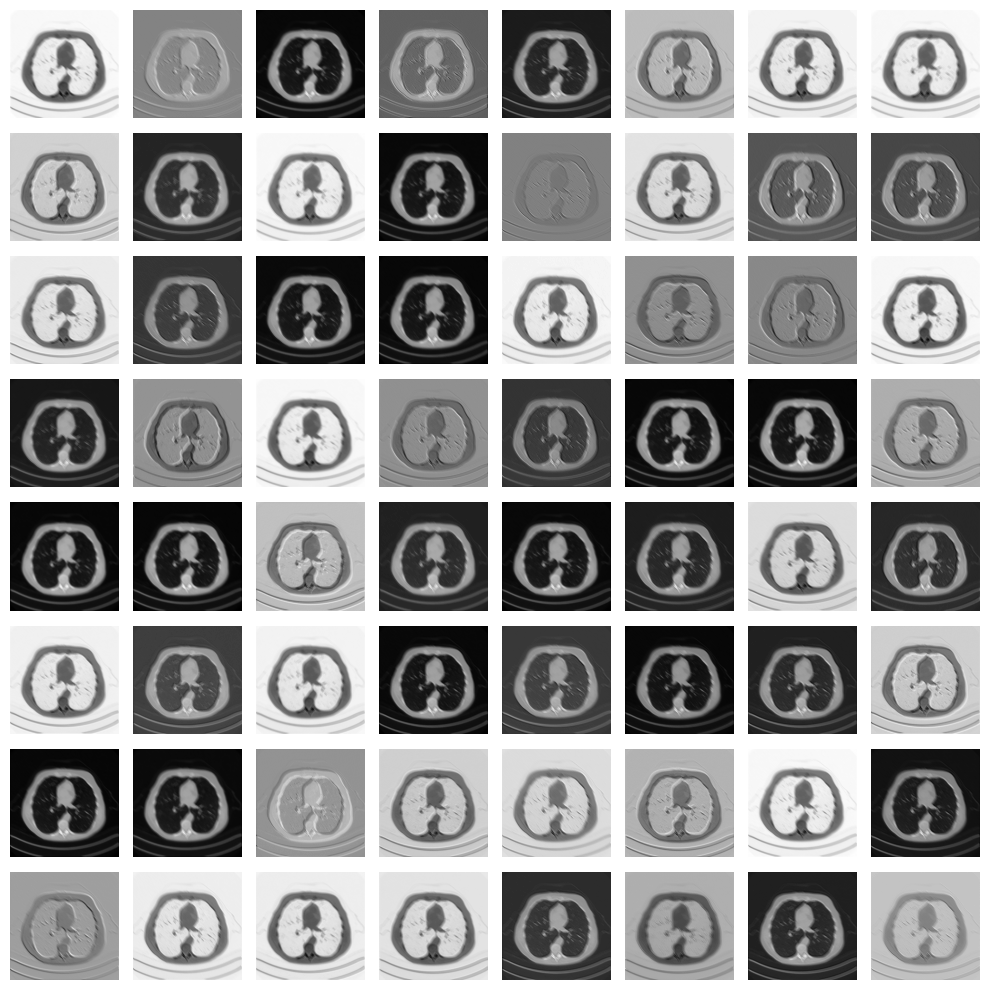

In [3]:
# Variable to store the output
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register the hook
model.conv1.register_forward_hook(get_activation('conv1'))

# Process image
x_rec = model(y_delta.to(device))

# Get the conv1 activation
conv1_output = activation['conv1']  # Shape: [1, 64, 256, 256]

# Plot all channels
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(conv1_output[0, i].cpu(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
# Get number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params}")

Total trainable parameters: 38145


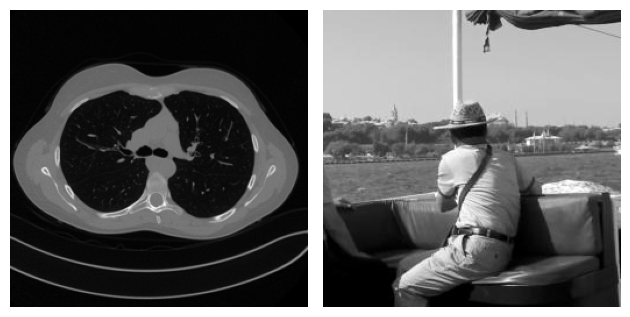

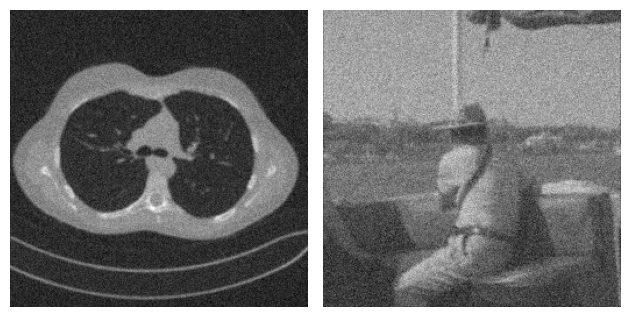

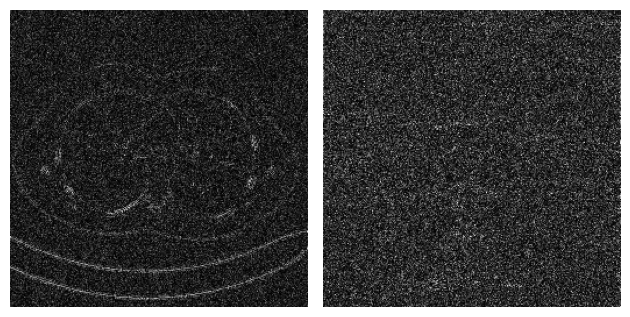

In [5]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPPy import operators
from torchvision import transforms

# Load images
x_mayo = torch.tensor(np.array(Image.open("../imgs/Mayo.png").convert("L"))).unsqueeze(0).unsqueeze(1)
x_mayo = transforms.Resize(size=256)(x_mayo)
x_mayo = (x_mayo - x_mayo.min()) / (x_mayo.max() - x_mayo.min())

x_gopro = torch.tensor(np.array(Image.open("../imgs/GoPro.jpg").convert("L"))).unsqueeze(0).unsqueeze(1)
x_gopro = transforms.Resize(size=256)(x_gopro)
x_gopro = (x_gopro - x_gopro.min()) / (x_gopro.max() - x_gopro.min())

# Visualize the images
plt.subplot(1, 2, 1)
plt.imshow(x_mayo.squeeze(), cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_gopro.squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Corrupt and add noise
K = operators.Blurring(img_shape=(256, 256), kernel_type="gaussian", kernel_size=3, kernel_variance=1)

y_mayo = K(x_mayo)
y_mayo_delta = y_mayo + utilities.gaussian_noise(y_mayo, noise_level=0.2)

y_gopro = K(x_gopro)
y_gopro_delta = y_gopro + utilities.gaussian_noise(y_gopro, noise_level=0.2)

# Visualize the (corrupted) images
plt.subplot(1, 2, 1)
plt.imshow(y_mayo_delta.squeeze(), cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y_gopro_delta.squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Visualize the residual
plt.subplot(1, 2, 1)
plt.imshow(torch.abs(y_mayo_delta - x_mayo).squeeze(), cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(torch.abs(y_gopro_delta - x_gopro).squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
import torch
from torch import nn

class ResCNN(nn.Module):
    def __init__(self, in_ch, out_ch, n_filters, kernel_size=3):
        super().__init__()

        # Define (convolution) layers -> NOTE: padding="same" means "padded convolution"
        self.conv1 = nn.Conv2d(in_channels=in_ch, out_channels=n_filters, kernel_size=kernel_size, padding="same")
        self.conv2 = nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=kernel_size, padding="same")
        self.conv3 = nn.Conv2d(in_channels=n_filters, out_channels=out_ch, kernel_size=kernel_size, padding="same")

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        h = self.relu(self.conv1(x))
        h = self.relu(self.conv2(h))
        out = self.tanh(self.conv3(h))
        return out + x

Shape of x_true: torch.Size([1, 1, 256, 256]). Range of x_true: (tensor(0.), tensor(1.))
SSIM: 0.9405


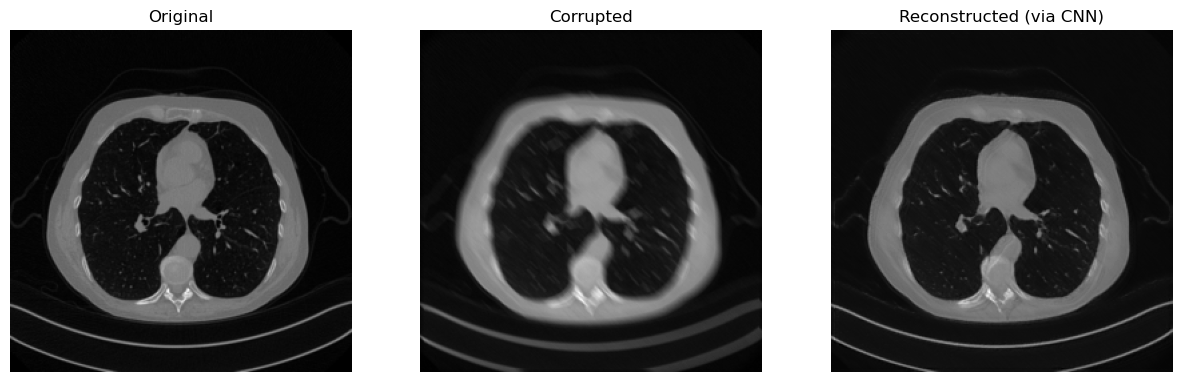

In [7]:
#-----------------
# This is just for rendering on the website
import os
import sys
import glob
sys.path.append("..")
#-----------------

from IPPy import operators, utilities, metrics

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = utilities.get_device()

# Define model
model = ResCNN(in_ch=1, out_ch=1, n_filters=64, kernel_size=3).to(device)

# Load model weights and send to CUDA
model.load_state_dict(torch.load("../weights/ResCNN.pth", weights_only=True, map_location=torch.device('cpu')))
model = model.to(device)

# Generate test image
class MayoDataset(Dataset):
    def __init__(self, data_path, data_shape):
        super().__init__()

        self.data_path = data_path
        self.data_shape = data_shape

        # We expect data_path to be like "./data/Mayo/train" or "./data/Mayo/test"
        self.fname_list = glob.glob(f"{data_path}/*/*.png")

    def __len__(self):
        return len(self.fname_list)
    
    def __getitem__(self, idx):
        # Load the idx's image from fname_list
        img_path = self.fname_list[idx]

         # To load the image as grey-scale
        x = Image.open(img_path).convert("L")

        # Convert to numpy array -> (512, 512)
        x = np.array(x) 

        # Convert to pytorch tensor -> (1, 512, 512) <-> (c, n_x, n_y)
        x = torch.tensor(x).unsqueeze(0)

        # Resize to the required shape
        x = transforms.Resize(self.data_shape)(x) # (1, n_x, n_y)

        # Normalize in [0, 1] range
        x = (x - x.min()) / (x.max() - x.min())

        return x

# Load test data   
test_data = MayoDataset(data_path="../data/Mayo/test", data_shape=256)
x_true = test_data[0].unsqueeze(0)

# Check whether it is a standardized tensor
print(f"Shape of x_true: {x_true.shape}. Range of x_true: {x_true.min(), x_true.max()}")

# Define MotionBlur operator (with a 45° angle)
K = operators.Blurring(img_shape=(256, 256), 
                       kernel_type="motion", 
                       kernel_size=7, 
                       motion_angle=45,)

# Compute blurred version of x_true
y = K(x_true)

# Add noise
y_delta = y + utilities.gaussian_noise(y, noise_level=0.01)

# Apply model to reconstruct image
x_rec = model(y_delta.to(device))

# Print SSIM
print(f"SSIM: {metrics.SSIM(x_rec.cpu(), x_true.cpu()):0.4f}")

# Visualize
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x_true.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(y_delta.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Corrupted')

plt.subplot(1, 3, 3)
plt.imshow(x_rec.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Reconstructed (via CNN)')
plt.show()